In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from pathlib import Path

wdir = Path.cwd()

Note: this code will not run in its current state since the NetMHCpan binding predictions is ~4.0 GB and can't be hosted on GitHub.

In [5]:
sns.set_theme('poster')
mpl.rcParams['figure.figsize'] = [10.0, 8.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

# Slow cell
bp = pd.read_feather(wdir.parent / 'Data' / 'taa_netmhcpan_el_ranks.fth')
bp.insert(1, 'end', bp.Pos + bp.Peptide.str.len() - 1)

chr_y = pd.read_csv(wdir.parent / 'Data' / 'chrY_genes.txt', sep='\t')
histones_df = pd.read_csv(wdir.parent / 'Data' / 'histones_hgnc.csv')
pseudos_df = pd.read_csv(wdir.parent / 'Data' / 'pseudogenes_hgnc.tsv', sep='\t')

histones = set(histones_df['Approved symbol'].tolist())
for s in histones_df['Previous symbols'].tolist():
    if s is np.nan:
        continue
    histones |= set(s.split(','))

pseudos = set(pseudos_df['Approved symbol'].tolist())
for s in pseudos_df['Previous symbol'].tolist():
    if s is np.nan:
        continue
    pseudos |= set(s.split(','))

gene_filter = (
    ~bp.hgnc.isin(chr_y)
    & ~bp.hgnc.isin(histones)
    & ~bp.hgnc.isin(pseudos)
)
bp = bp[gene_filter]

gene_lengths = bp.groupby('hgnc')['Pos'].max() + 8
gene_lengths.sort_values().head()

gene_seqs = pd.read_csv(wdir.parent / 'Data' / 'ca_amino_seq.csv')

## Get alleles of interest
ai_alleles =  {'HLA-B27:05', 'HLA-B57:01', 'HLA-B13:02', 'HLA-B39:06', 'HLA-B51:01', 'HLA-C12:03', 'HLA-C06:02'}
ai_B_alleles = {'HLA-B27:05', 'HLA-B57:01', 'HLA-B13:02', 'HLA-B39:06', 'HLA-B51:01'}
ai_C_alleles = {'HLA-C06:02','HLA-C12:03'}

hla_b_af = pd.read_csv(wdir.parent / 'Data' / 'HLA_Population_Frequencies' / 'HLA_B.tsv', sep='\t', header=0, names=['allele', 'af'])
hla_c_af = pd.read_csv(wdir.parent / 'Data' / 'HLA_Population_Frequencies' / 'HLA_C.tsv', sep='\t', header=0, names=['allele', 'af'])

def get_pop_alleles(freqs):
    if isinstance(freqs, pd.DataFrame):
        freqs = [freqs]
    alleles = set()
    for df in freqs:
        alleles.update(df[df.af >= 0.01].allele.tolist())
    return {'HLA-'+al.replace('*', '') for al in alleles}

pop_alleles = get_pop_alleles([hla_b_af, hla_c_af]) - ai_alleles

pop_B_alleles = get_pop_alleles(hla_b_af) - ai_alleles

pop_C_alleles = get_pop_alleles(hla_c_af) - ai_alleles

allele_colors = {'HLA-B51:01': 'brown', 'HLA-B57:01': 'orange', 'HLA-B27:05': 'red', 'HLA-B39:06': 'green', 'HLA-B13:02': 'blue',
                 'HLA-C06:02': 'purple', 'HLA-C12:03': 'cyan'}

de_atgns = ['PMEL', 'TYR', 'GPNMB', 'MAGEA10', 'MAGEE1', 'TYRP1', 'MITF', 'MTMR2', 'TIAF1', 'MTMR4', 'DCT', 'MLANA']

### Helpers

In [6]:
def bestrank_seqalong(bp, gene, alleles=None, **kwargs):
    
    gene = gene.upper()
    if 'ORF' in gene:
        not_orf = gene.split('ORF')
        gene = not_orf[0] + 'orf' + not_orf[1]
    assert gene in bp.hgnc.unique(), "Cannot find gene in set of binding predictions."
    
    if kwargs.get('how') is None:
        kwargs['how'] = 'all'
    
    if alleles is None:
        cols = bp.columns[~bp.columns.isin(['Pos', 'end', 'Peptide', 'uniprot', 'hgnc'])]
        df = bp.loc[bp.hgnc == gene, bp.columns.isin({'Pos', 'end'}) | bp.columns.isin(cols)].copy()
    else:
        cols = alleles
        df = bp.loc[bp.hgnc == gene, ['Pos', 'end'] + list(cols)].copy()
    
    # df = bp.loc[bp.hgnc == gene, {'Pos', 'end'}].copy()
    df.sort_values(['Pos', 'end'], inplace=True)
    
    gene_length = df.Pos.max() + 8
    
    s = df.Pos.values
    e = df.end.values
    
    if kwargs['how'] == 'all':
        # df['best_rank'] = bp.loc[bp.hgnc == gene, cols].min(1)
        # df['best_allele'] = bp.loc[bp.hgnc == gene, cols].idxmin(1)
        r_min = df[cols].min(1).values
        allele_min = df[cols].idxmin(1).values
        mins = np.empty(gene_length)
        alleles = [None] * gene_length
        
        # How to vectorize thisss
        for i in range(0, e[-1] + 1):
            idx = r_min[(i >= s) & (i <= e)].argmin()
            mins[i] = r_min[(i >= s) & (i <= e)][idx]
            alleles[i] = allele_min[(i >= s) & (i <= e)][idx]
        res = pd.DataFrame({'metric': mins, 'best_allele': alleles})
        
    elif kwargs['how'] == 'each':
        res = pd.DataFrame(columns=alleles)
        for al in alleles:
            r_min = df[al].values
            mins = np.empty(gene_length)
            for i in range(0, e[-1] + 1):
                mins[i] = r_min[(i >= s) & (i <= e)].min()
            res[al] = mins
    
    return res

def thresh_cnt_seqalong(bp, gene, alleles=None, **kwargs):
    if kwargs.get('thresh') is None:
        kwargs['thresh'] = 2
    if kwargs.get('how') is None:
        kwargs['how'] = 'all'
    
    gene = gene.upper()
    if 'ORF' in gene:
        not_orf = gene.split('ORF')
        gene = not_orf[0] + 'orf' + not_orf[1]
    assert gene in bp.hgnc.unique(), "Cannot find gene in set of binding predictions."
        
    if alleles is None:
        cols = ~bp.columns.isin(['Pos', 'end', 'Peptide', 'uniprot', 'hgnc'])
        n_alleles = bp.loc[bp.hgnc == gene, 'HLA-A01:01':].shape[1]
    else:
        cols = alleles
        n_alleles = len(alleles)
    
    df = bp.loc[bp.hgnc == gene, bp.columns.isin({'Pos', 'end'})].copy()
    if kwargs['how'] == 'all':
        # Get df of Pos, end, and # of alleles meeting threshold
        df['cnt'] = (bp.loc[bp.hgnc == gene, cols] <= kwargs.get('thresh')).sum(1)
        
        s_cnts = df.groupby('Pos')['cnt'].sum().cumsum().to_frame().reset_index()
        e_cnts = df.groupby('end')['cnt'].sum().cumsum().to_frame().reset_index()
        
        df = s_cnts.merge(e_cnts, left_on='Pos', right_on='end', how='outer')
        means = (df.cnt_x.fillna(method='ffill') - df.cnt_y.fillna(method='bfill'))/n_alleles
        res = pd.DataFrame({'metric': means})
    elif kwargs['how'] == 'each':
        res = pd.DataFrame(columns=alleles)
        for al in alleles:
            al_df = df
            al_df['cnt'] = bp.loc[bp.hgnc == gene, al] <= kwargs.get('thresh')
            s_cnts = df.groupby('Pos')['cnt'].sum().cumsum().to_frame().reset_index()
            e_cnts = df.groupby('end')['cnt'].sum().cumsum().to_frame().reset_index()
            al_df = s_cnts.merge(e_cnts, left_on='Pos', right_on='end', how='outer')
            res[al] = (al_df.cnt_x.fillna(method='ffill') - al_df.cnt_y.fillna(method='bfill'))
            
    return res

def plot_ai_vs_pop(bp, genes, *, hla_type='all', kind='bestrank', how=None, max_ncols=5, savefig_kws=None, **kwargs):
    
    
    ## Pre-define all allele sets
    if hla_type == 'all':
        ai_alleles = ['HLA-C06:02', 'HLA-B35:01', 'HLA-B27:05', 'HLA-B57:01', 'HLA-B50:01', 'HLA-B51:01', 'HLA-C12:03', 'HLA-B13:02']
        pop_alleles = [
            'HLA-B39:01', 'HLA-C05:01', 'HLA-B37:01', 'HLA-B38:01', 'HLA-B55:01', 'HLA-B14:02', 'HLA-C14:02', 'HLA-B44:03', 'HLA-B35:02',
            'HLA-B35:03', 'HLA-B49:01', 'HLA-C01:02', 'HLA-C15:02', 'HLA-C03:04', 'HLA-C16:01', 'HLA-B15:01', 'HLA-C07:02', 'HLA-C08:02',
            'HLA-B14:01', 'HLA-C04:01', 'HLA-B40:01', 'HLA-C07:04', 'HLA-B40:02', 'HLA-C02:02', 'HLA-C07:01', 'HLA-B07:02', 'HLA-B08:01',
            'HLA-B18:01', 'HLA-B44:02', 'HLA-C03:03'
        ]
    elif hla_type == 'B':
        ai_alleles = ['HLA-B13:02', 'HLA-B57:01', 'HLA-B51:01', 'HLA-B35:01', 'HLA-B27:05', 'HLA-B50:01']
        pop_alleles = [
            'HLA-B07:02', 'HLA-B55:01', 'HLA-B14:02', 'HLA-B15:01', 'HLA-B44:03', 'HLA-B08:01', 'HLA-B35:02',
            'HLA-B39:01', 'HLA-B35:03', 'HLA-B37:01', 'HLA-B14:01', 'HLA-B40:01', 'HLA-B18:01', 'HLA-B44:02',
            'HLA-B40:02', 'HLA-B38:01', 'HLA-B49:01'
        ]
    elif hla_type == 'C':
        ai_alleles = ['HLA-C12:03', 'HLA-C06:02']
        pop_alleles = ['HLA-C15:02', 'HLA-C03:04', 'HLA-C01:02', 'HLA-C16:01', 'HLA-C14:02', 'HLA-C07:02', 'HLA-C08:02', 'HLA-C05:01',
                       'HLA-C04:01', 'HLA-C07:04', 'HLA-C02:02', 'HLA-C07:01', 'HLA-C03:03']
        
    # Check how
    if how is None:
        how = {'ai': 'all', 'pop': 'all'}
    elif isinstance(how, str):
        how = {'ai': how, 'pop': how}
    
    # Check kind
    if kind == 'threshcnt':
        seqalong_fun = thresh_cnt_seqalong
        if kwargs.get('thresh') is None:
            kwargs['thresh'] = 2
    elif kind == 'bestrank':
        seqalong_fun = bestrank_seqalong
    
    ## Helper function to handle all plotting
    def _plot_1gene(gene, kind, how, xlims=None, ax=None, **kwargs):
        ai_res = seqalong_fun(bp, gene, ai_alleles, how=how['ai'], **kwargs)
        pop_res = seqalong_fun(bp, gene, pop_alleles, how=how['pop'], **kwargs)
        
        if ax is None:
            fig, ax = plt.subplots()
        
        if kind == 'bestrank':
            if how['pop'] == 'all':
                ax.plot(pop_res.metric, c='black', label='Population')
            elif how['pop'] == 'each':
                ax.plot(pop_res, color='black', alpha=0.1)
            if how['ai'] == 'all':
                ax.plot(ai_res.metric, c='C0', label='Autoimmune')
            elif how['ai'] == 'each':
                if xlims is not None:
                    cnt_als_below_thresh = 0
                    for al in ai_alleles:
                        if ai_res.loc[xpos[idx], al] < 0.5:
                            cnt_als_below_thresh += 1
                            ax.plot(ai_res[al], color=allele_colors[al], label=al)
                    losing_alleles = ai_res.loc[xpos[idx]] > 0.5
                    ax.plot(ai_res.loc[:, losing_alleles], color='C0', alpha=0.2, label='Autoimmune')
                    ax.set(ylim=(None, pop_res.loc[xlows[idx]:xhighs[idx]+1, 'metric'].max()+10))
                else:
                    ax.plot(ai_res, color='C0', alpha=0.5)
            ax.axhline(0.5, c='grey', alpha=0.5, ls='--')
            ax.axhline(2, c='grey', alpha=0.5, ls='--')
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:2+cnt_als_below_thresh], labels=labels[:2+cnt_als_below_thresh], loc='lower left')
            
        if kind == 'threshcnt':
            if how['pop'] == 'all':
                ax.plot(pop_res.metric, color='black', label='Population')
            elif how['pop'] == 'each':
                ax.plot(pop_res, color='black', alpha=0.1)
            if how['ai'] == 'all':
                ax.plot(ai_res.metric, color='C0', label='Autoimmune')
            elif how['ai'] == 'each':
                ax.plot(ai_res, color='C0', alpha=0.5)
    
    # Check for limits on plotting range
    if isinstance(kwargs.get('xlims'), pd.DataFrame):
        xlims = kwargs['xlims']
        xlows = xlims['xlow'].values
        xhighs = xlims['xhigh'].values
        xpos = xlims['Pos'].values
    else:
        xlims = None
        xpos = None
    
    ## Only 1 gene is passed
    if isinstance(genes, str):
        gene = genes.upper()
        if 'ORF' in gene:
            not_orf = gene.split('ORF')
            gene = not_orf[0] + 'orf' + not_orf[1]
        assert gene in bp.hgnc.unique(), "Cannot find gene in set of binding predictions."
        _plot_1gene(gene, kind=kind, how=how, **kwargs)
        plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        if kind == 'bestrank':
            plt.ylabel('Best Eluted %rank')
        if kind == 'threshcnt':
            plt.ylabel(f'Ave. # of peptides with % rank $\leq$ {kwargs.get("thresh")}')
        plt.xlabel(f'Position along {gene}')
        if 'all' in how.values():
            plt.legend()
            
        ## Plot MHD if applicable
        # if gene in mhd.hgnc.values:
        #     mhd_span = mhd.loc[mhd.hgnc == gene, 'mhd_range'].str.split('-', expand=True).astype(int).values
        #     for span in mhd_span:
        #         ax.axvspan(span[0], span[1], color='grey', alpha=0.15)
            
    ## Multiple genes are passed
    else:
        for gene in genes:
            gene = gene.upper()
            if 'ORF' in gene:
                not_orf = gene.split('ORF')
                gene = not_orf[0] + 'orf' + not_orf[1]
#         gene_check = set(genes) ^ set(bp.hgnc.unique())
#         if len(gene_check) > 0:
            
        ncols = min(len(genes), max_ncols)
        nrows = -(len(genes)//-ncols)
        
        fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols+1, 5*nrows+1), sharey=True)
        for idx, gene in enumerate(genes):
            ax = axs.flatten()[idx]
            if xpos is not None:
                ax.axvline(xpos[idx], c='tab:purple', alpha=0.8)
            _plot_1gene(gene, kind=kind, how=how, ax=ax, **kwargs)
            # ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            # ax.set_title(gene)
            if isinstance(xlims, pd.DataFrame):
                ax.set_xlim(xlows[idx], xhighs[idx])
            
            ## Plot MHD if applicable
            # if gene in mhd.hgnc.values:
            #     mhd_span = mhd.loc[mhd.hgnc == gene, 'mhd_range'].str.split('-', expand=True).astype(int).values
            #     for span in mhd_span:
            #         ax.axvspan(span[0], span[1], color='grey', alpha=0.15)
            
            ax.set(title=gene)
        
        for ax in axs.flatten()[idx+1:]:
            ax.axis('off')
        
        # Figure level config
        if kind == 'bestrank':
            fig.supylabel('Best Eluted % Rank')
        if kind == 'threshcnt':
            fig.supylabel(f'Ave. # of peptides with % rank $\leq$ {kwargs.get("thresh")}')
        fig.supxlabel('Position')
        fig.tight_layout(pad=2)
        # legend_elements = [
        #     mpl.lines.Line2D([0], [0], color='C0', alpha=0.5, label='Autoimmune'),
        #     mpl.lines.Line2D([0], [0], color='black', label='Population')
        # ]
        # lgd = plt.legend(handles=legend_elements, loc='best', bbox_to_anchor=(0.5, 0.), borderaxespad=0, ncol=1, fontsize='large')
        if savefig_kws is not None:
            fig.savefig(**savefig_kws)

### Fig. S2A

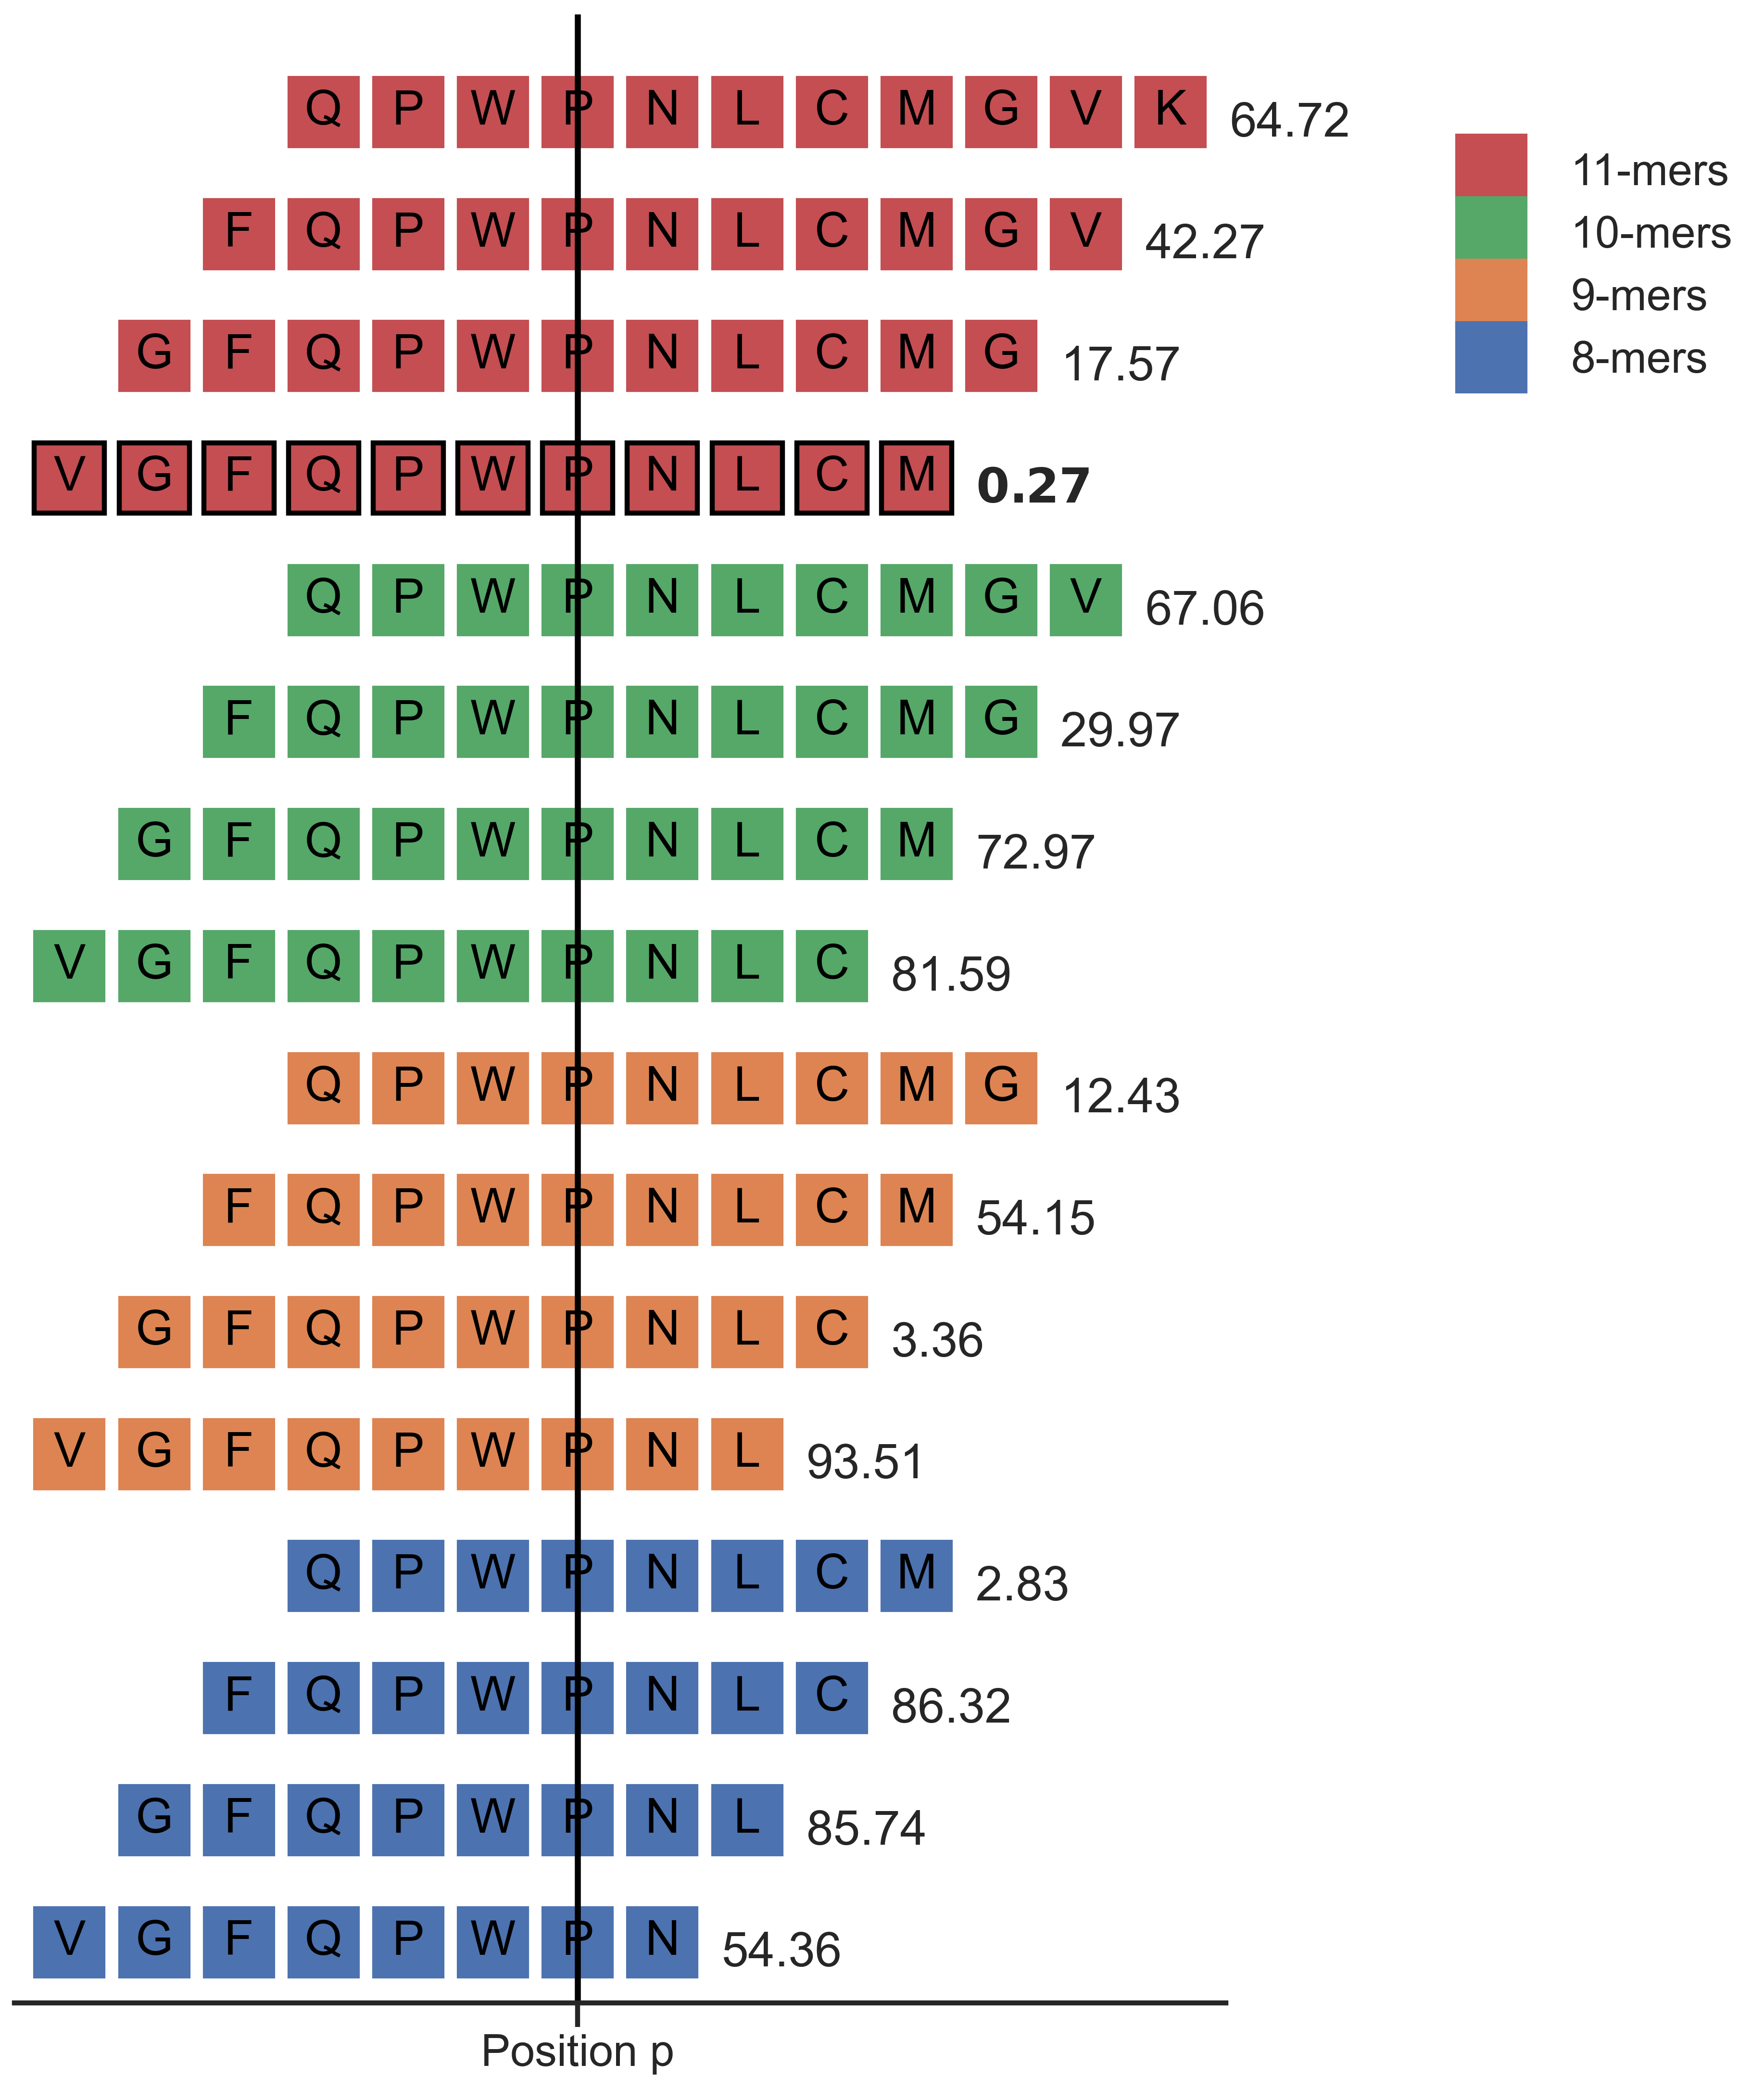

In [12]:
from string import ascii_uppercase
amino_acids = np.array(list(set(ascii_uppercase) - {'B', 'J', 'O', 'U', 'X', 'Z', 'I', 'Y', 'T'}))

sns.set_theme('poster', font='Arial Black')
sns.set_style('ticks')
lengths = np.arange(8, 12)
starts = np.arange(1, 5)
ys = np.arange(1, len(lengths)*len(starts)+1).reshape(len(starts), len(lengths))
rng = np.random.default_rng(seed=0)
protein_seq = rng.choice(amino_acids, starts.max() + lengths.max())
scores = rng.uniform(0, 100, size=(len(starts), len(lengths)))
colors = ['C0', 'C1','C2', 'C3']
labels = [f'{k}-mers' for k in lengths]
fig, ax = plt.subplots(figsize=(13, 15), dpi=300)
for i in range(len(starts)):
    for j in range(len(lengths)):
        s = starts[i]
        c = colors[j]
        l = lengths[j]
        y = ys[j, i]
        ps = np.arange(s, s+l)
        plt_ys = np.ones(l) * y
        score = scores[i, j]
        aas = protein_seq[s:s+l]
        if score == scores.min():
            ax.plot(ps, plt_ys, marker='s', ls='', color=c, ms=35, markeredgewidth=2.5, markeredgecolor='black')
            ax.annotate(f'$\\bf{{{score:.2f}}}$', xy=(s+l-1,y), xytext=(s+l-0.3, y-0.2))
        else:
            ax.plot(ps, plt_ys, marker='s', ls='', color=c, ms=35)
            ax.annotate(f'{score:.2f}', xy=(s+l-1,y), xytext=(s+l-0.3, y-0.2))
        for idx, aa in enumerate(aas):
            ax.annotate(f'{aa}', xy=(ps[idx], plt_ys[idx]), va='center', ha='center', color='black')
sns.despine(left=True)
plt.yticks(ticks=[], labels=[])
plt.xticks(ticks=[7], labels=['Position p'])
plt.axline((7,0), slope=np.inf, c='black')
plt.ylim([0.5, None])
handles = [mpl.lines.Line2D([], [], marker='s', ls='', color=c, ms=35, label=lab) for c, lab in zip(reversed(colors), reversed(labels))]
lgd = plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.15, 0.95), frameon=False)
plt.tight_layout();

### Fig. S2B

In [7]:
# Slow cell
ai_B_ranks = {}
pop_B_ranks = {}
for gene in bp.hgnc.unique():
    ai_B_ranks[gene] = bestrank_seqalong(bp, gene, list(ai_B_alleles), how='all').metric
    pop_B_ranks[gene] = bestrank_seqalong(bp, gene, list(pop_B_alleles), how='all').metric

important_B_diffs = {}
rank0_5 = 0.5
rank2 = 2
for gene in bp.hgnc.unique():
    important = (ai_B_ranks[gene] < rank0_5) & (pop_B_ranks[gene] > rank2)
    v = ai_B_ranks[gene][important] - pop_B_ranks[gene][important]
    important_B_diffs[gene] = pd.DataFrame({'Pos': v.index, 'difference': v.values, 'hgnc': np.repeat(gene, v.shape[0])})

important_B_diffs = pd.concat(important_B_diffs.values(), ignore_index=True)
important_B_max_diffs = important_B_diffs.loc[important_B_diffs.groupby('hgnc').difference.idxmin()]

window_size = 40
important_B_max_diffs = important_B_max_diffs.assign(
    xlow=np.maximum(-1, important_B_max_diffs.Pos - window_size//2),
    xhigh=np.minimum(
        (important_B_max_diffs.Pos + window_size//2).values,
        gene_lengths[gene_lengths.index.isin(important_B_max_diffs.hgnc.unique())].values+1
    )
)
important_B_max_diffs.sort_values('difference', ascending=True, inplace=True)

top10 = important_B_max_diffs[~important_B_max_diffs.hgnc.isin(de_atgns)].nsmallest(10, 'difference').hgnc

B_diffs = important_B_max_diffs[
    important_B_max_diffs.hgnc.isin(de_atgns)
    | important_B_max_diffs.hgnc.isin(top10)
].copy()
B_diffs['ref'] = [seq[pos]+str(pos) for seq, pos in zip(gene_seqs.set_index('hgnc').loc[B_diffs.hgnc, 'sequence'].values, B_diffs.Pos.values)]
B_diffs.sort_values('difference', inplace=True)
to_keep = ['SRSF8', 'PMEL', 'TYR', 'MAGEA10', 'MAGEE1', 'GPNMB']
data = B_diffs[B_diffs['hgnc'].isin(to_keep)]

In [ ]:

sns.set_theme(font='Arial Black', font_scale=1.5)
sns.set_style('white')
plot_ai_vs_pop(
    bp,
    data['hgnc'].tolist(),
    kind='bestrank',
    how={'ai': 'each', 'pop': 'all'},
    hla_type='B',
    xlims=data.loc[:, ['xlow', 'xhigh', 'Pos']],
    max_ncols=3,
);

### Fig. S17

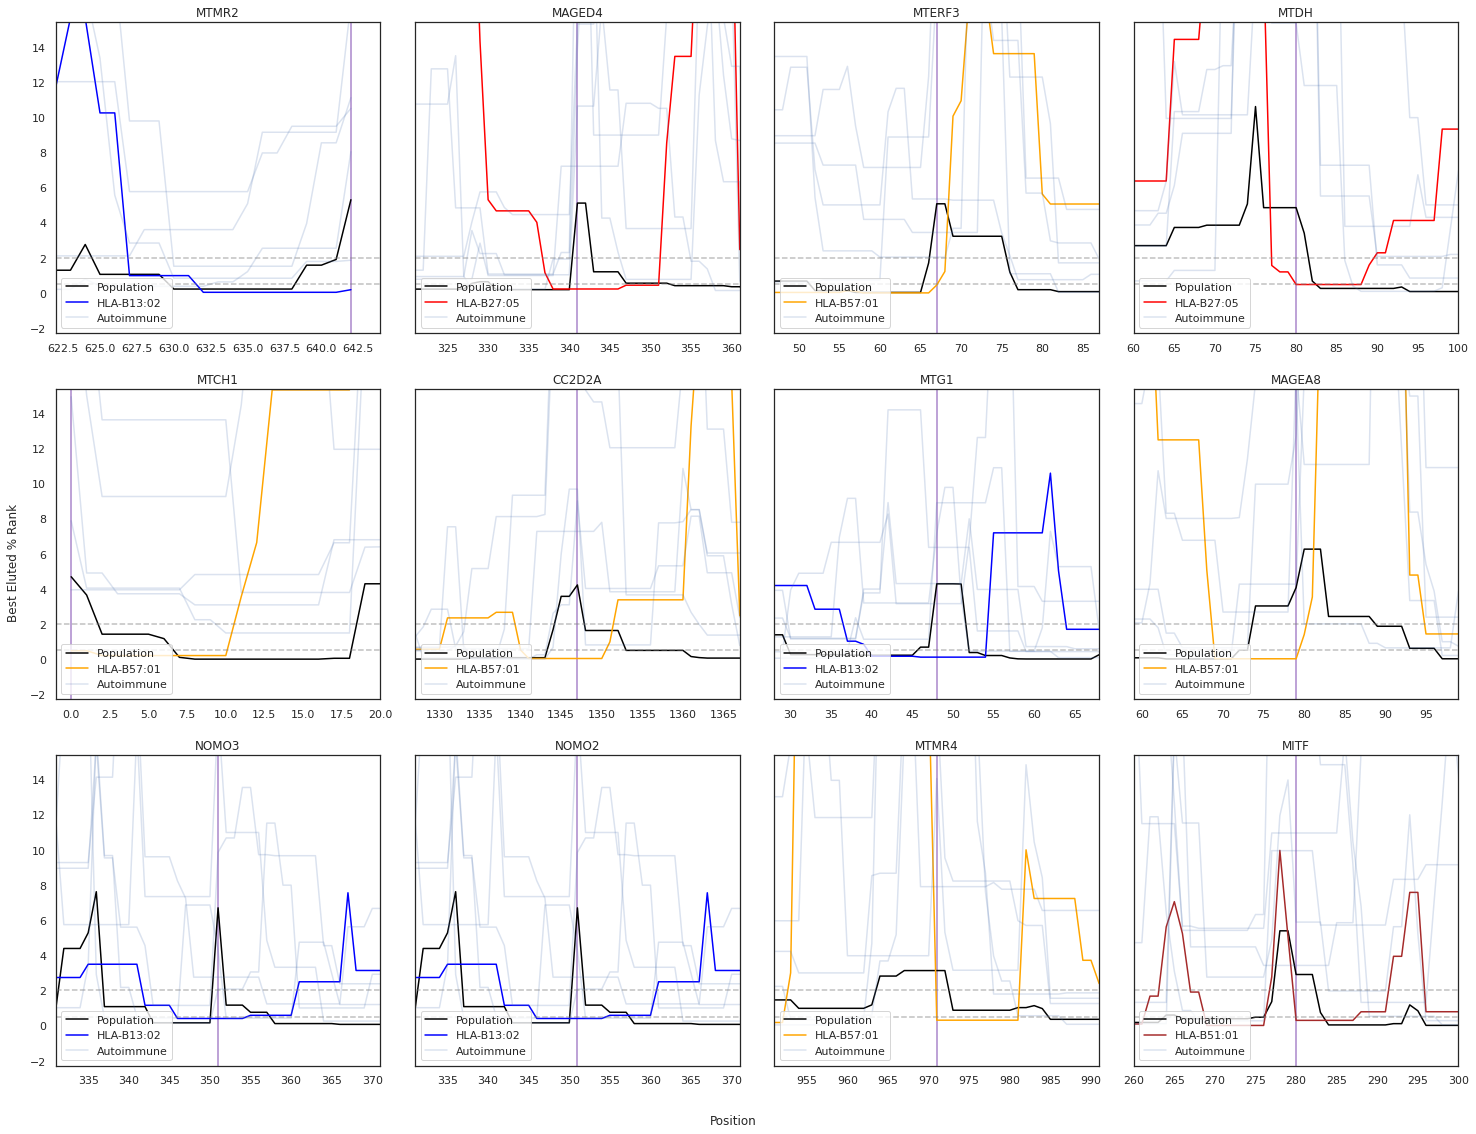

In [8]:
data = B_diffs[~B_diffs['hgnc'].isin(to_keep)]
sns.set_theme()
sns.set_style('white')
plot_ai_vs_pop(
    bp,
    data['hgnc'].tolist(),
    kind='bestrank',
    how={'ai': 'each', 'pop': 'all'},
    hla_type='B',
    xlims=data.loc[:, ['xlow', 'xhigh', 'Pos']],
    max_ncols=4,
)
plt.savefig(wdir.parent / 'Figures' / 'Supplementary' / 'FigS17' / 'SupplementaryFig17.pdf', dpi=300)